<u>Course Title</u>      : Deep Learning  
<u>Course Instructor</u> : Dr. Hassan Mohy-ud-Din  
<u>Department</u>        : Department of Electrical Engineering  

<u>Date</u>              : September 19, 2024


# Deep Learning - Assignment #2

### Setup Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/My\ Drive/DL/

import sys
sys.path.append('/content/drive/My Drive/DL/')

import glob

Mounted at /content/drive
 best_model  'Colab Notebooks'	 __pycache__   testing.py   utils_.py


In [ ]:
# Import numpy
import numpy as np
np.random.seed(219)

# Import matplotlib
import matplotlib.pyplot as plt

# Import other libraries
from typing import Callable, Tuple, Union
from testing import *
from utils_ import draw_models, draw_loss_function, plot_data, plot_loss_curves, plot_auto_reduce, plot_poly_decay

## Part 1: Optimization Methods for Linear Regression (60 points)

### 1.1 Gradient Descent (3 points)

In [ ]:
def gradient_descent_step(gradient: np.ndarray, prev_theta: np.ndarray, lr: float) -> np.ndarray:
    """
    Perform a single step of gradient descent.
    Args:
        gradient: The gradient of the loss function at the previous weights.
        prev_theta: The previous weights.
        lr: The learning rate.
    Returns:
        The updated weights.
    """
    theta = prev_theta - lr * gradient

    return theta

In [ ]:
# ----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
test_gd(gradient_descent_step)

All tests passed!


### 1.2 Nestrov Accelerated Momentum (7 points)

In [ ]:
def nestrov_acc_momentum_step(gradient: np.ndarray, prev_theta: np.ndarray, prev_v: np.ndarray, beta: float, lr: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a single step of Nesterov accelerated gradient descent.
    Args:
        gradient: The gradient of the loss function at predicted point with previous weights.
        prev_theta: The previous weights.
        prev_v: The previous momentum.
        beta: The momentum coefficient.
        lr: The learning rate.
    Returns:
        The updated weights and momentum.
    """

    v = None
    theta = None
    theta_hat = prev_theta - lr * beta * prev_v

    v = beta * prev_v + (1 - beta) * gradient

    theta = prev_theta - lr * v

    return theta, v

In [ ]:
# ----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
test_nm(nestrov_acc_momentum_step)

All tests passed!


### 1.3 Adaptive Moment Estimation (10 points)

In [ ]:
def adam_step(iteration_num: int, gradient: np.ndarray, prev_theta: np.ndarray, prev_m: np.ndarray, prev_v: np.ndarray, beta: float, gamma: float, epsilon: float, lr: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform a single step of Adam.
    Args:
        iteration_num: The iteration number.
        gradient: The gradient of the loss function at the previous weights.
        prev_theta: The previous weights.
        prev_m: The previous first moment.
        prev_v: The previous second moment.
        beta: The first moment coefficient.
        gamma: The second moment coefficient.
        epsilon: The epsilon value for numerical stability.
        lr: The learning rate.
    Returns:
        The updated weights, first moment, and second moment.
    """

    m = beta * prev_m + (1 - beta) * gradient

    v = gamma * prev_v + (1 - gamma) * (gradient ** 2)


    m_tilde = m / (1 - beta ** (iteration_num + 1))


    v_tilde = v / (1 - gamma ** (iteration_num + 1))

    theta = prev_theta - lr * (m_tilde / (np.sqrt(v_tilde) + epsilon))

    return theta, m, v

In [ ]:
# ----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
test_adam(adam_step)

All tests passed!


### 1.4 The Linear Regression Model (15 points)

#### 1.4.1 Data Generation

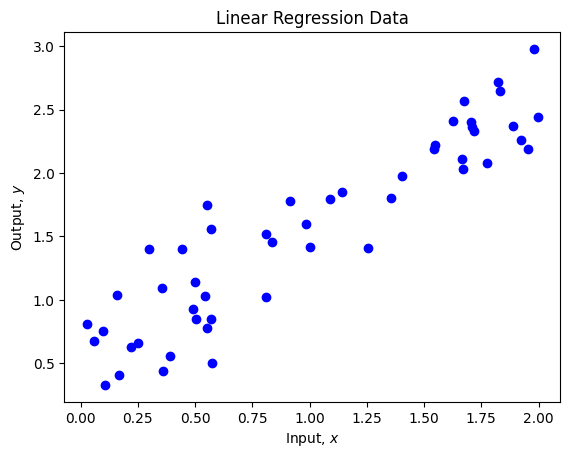

In [ ]:
# ----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
#  Run the cell to generate data for LR model
data_x = np.random.uniform(low=0, high=2, size=50)
epsilon = np.random.normal(loc = 0.0, scale = 0.3, size=50)
data_y = 1 * data_x + 0.5 + epsilon

plot_data(data_x, data_y, "Linear Regression Data")

#### 1.4.2 The `LinearRegression` class (10 points)

In [ ]:
class LinearRegressionModel:
    def __init__(self, data_x: np.ndarray, data_y: np.ndarray, theta: np.ndarray, optimizer_name: str, lr: float, num_batches: int, max_epochs: int):

        self.name = 'LinearRegression'
        self.varient = optimizer_name

        self.data_x = data_x
        self.data_y = data_y

        self.num_batches = num_batches
        self.max_epochs = max_epochs

        self.theta = theta
        self.lr = lr

        self.theta_history = []
        self.theta_history.append(self.theta)

        self.loss_history = []

        self.optimizer_name = optimizer_name
        valid_names = ["gradient_descent", "sgd", "nestrov", "adam"]
        assert self.optimizer_name in valid_names, f"Name Error: optimizer_name should be one of the follows: {valid_names}"

        if self.optimizer_name == 'gradient_descent' or self.optimizer_name == "sgd":
            self.optimizer_step = gradient_descent_step
        elif self.optimizer_name == 'nestrov':
            self.v = np.zeros(self.theta.shape)
            self.beta = 0.9
            self.optimizer_step = nestrov_acc_momentum_step
        elif self.optimizer_name == 'adam':
            self.m = np.zeros(self.theta.shape)
            self.v = np.zeros(self.theta.shape)
            self.beta_1 = 0.9
            self.beta_2 = 0.999
            self.epsilon = 1e-8
            self.optimizer_step = adam_step

    def model(self, data_x: np.ndarray) -> np.ndarray:

        y_pred = self.theta[0] + self.theta[1] * data_x

        return y_pred

    def compute_cost(self, data_x: np.ndarray, data_y: np.ndarray) -> np.ndarray:

        m = len(data_y)  # Number of data points
        predictions = self.model(data_x)  # Get predicted values using the model

        # Compute the squared errors
        squared_errors = (predictions - data_y) ** 2

        # Compute the cost (mean squared error)
        cost = np.sum(squared_errors)


        return cost

    def compute_gradient(self, data_x: np.ndarray, data_y: np.ndarray) -> np.ndarray:
        if self.optimizer_name == 'nestrov':
            theta_tilde = self.theta - self.lr * self.beta * self.v
            predictions = theta_tilde[0] + theta_tilde[1] * data_x

            errors = predictions - data_y
            gradient_theta_0 = np.sum(2*errors)
            gradient_theta_1 = np.sum(2*errors * data_x)
            self.v[0] = self.beta * self.v[0] + (1 - self.beta) * gradient_theta_0
            self.v[1] = self.beta * self.v[1] + (1 - self.beta) * gradient_theta_1
        else:
            predictions = self.model(data_x)
            errors = predictions - data_y
            gradient_theta_0 = np.sum(2*errors)
            gradient_theta_1 = np.sum(2*errors * data_x)

        gradient = np.array([[gradient_theta_0], [gradient_theta_1]])
        return gradient

#### 1.4.3 LR model setups (5 points)

In [ ]:
initial_theta = np.array([[0.25], [-0.3]])
num_batches = 10
max_epochs = 30

lr_model_gd = LinearRegressionModel(data_x=data_x, data_y=data_y, theta=initial_theta, optimizer_name="gradient_descent", lr=0.001, num_batches=1, max_epochs=max_epochs)

lr_model_sgd = LinearRegressionModel(data_x=data_x, data_y=data_y, theta=initial_theta, optimizer_name="sgd", lr=0.001, num_batches=num_batches, max_epochs=max_epochs)

lr_model_nestrov = LinearRegressionModel(data_x=data_x, data_y=data_y, theta=initial_theta, optimizer_name="nestrov", lr=0.001, num_batches=num_batches, max_epochs=max_epochs)

lr_model_adam = LinearRegressionModel(data_x=data_x, data_y=data_y, theta=initial_theta, optimizer_name="adam", lr=0.01, num_batches=num_batches, max_epochs=max_epochs)

### 1.5 `train_model` function (10 points)

In [ ]:
def train_model(model: object, lr_decay_fn: Callable = None, interval: int = 5) -> None:
    """
    Train the model using the optimizer specified in the model.
    Updates the model weights, "theta", and stores the history of weights and loss.
    Args:
        model: The model object.
        lr_decay_fn: A learning rate decay schedule function.
        interval: The print interval (in epochs) of training.
    Returns:
        None
    """
    print(f"#------------ Training {model.name} - {model.varient} ------------ #")
    for epoch in range(0, model.max_epochs + 1):
        loss_epoch = 0

        shuffled_indices = np.random.permutation(len(model.data_x))
        batches = np.array_split(shuffled_indices, model.num_batches)

        for batch in batches:


            data_x_batch = model.data_x[batch]
            data_y_batch = model.data_y[batch]

            loss_epoch += model.compute_cost(data_x_batch, data_y_batch)
            gradient = model.compute_gradient(data_x_batch, data_y_batch)

            if model.optimizer_name == 'gradient_descent' or model.optimizer_name == "sgd":
                model.theta = model.optimizer_step(gradient, model.theta, model.lr)
            elif model.optimizer_name == 'nestrov':
                model.theta, model.v = model.optimizer_step(gradient, model.theta, model.v, model.beta, model.lr)
            elif model.optimizer_name == 'adam':
                model.theta, model.m, model.v = model.optimizer_step(epoch, gradient, model.theta, model.m, model.v, model.beta_1, model.beta_2, model.epsilon, model.lr)

            model.theta_history.append(model.theta)

        model.loss_history.append(loss_epoch)
        if epoch % interval == 0:
            print(f"Epoch: {epoch} | Loss: {loss_epoch:.3f} | theta_0: {model.theta[0][0]:.3f} | theta_1: {model.theta[1][0]:.3f}")
        if epoch == max_epochs:
            print(f"\n")

        if model.varient == "auto_reduce":
            model.lr = model.lr_decay_fn(model.initial_lr, model.eta, epoch, model.max_epochs, model.n_events)
        elif model.varient == "poly_decay":
            model.lr = model.lr_decay_fn(model.initial_lr, model.final_lr, epoch, model.max_epochs, model.eta)

    model.theta_history = np.array(model.theta_history).squeeze().T

### 1.6 LR models training (15 points)

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to train the models
train_model(lr_model_gd)
train_model(lr_model_sgd)
train_model(lr_model_nestrov)
train_model(lr_model_adam)

#------------ Training LinearRegression - gradient_descent ------------ #
Epoch: 0 | Loss: 168.051 | theta_0: 0.410 | theta_1: -0.087
Epoch: 5 | Loss: 20.260 | theta_0: 0.792 | theta_1: 0.466
Epoch: 10 | Loss: 7.526 | theta_0: 0.875 | theta_1: 0.647
Epoch: 15 | Loss: 6.077 | theta_0: 0.875 | theta_1: 0.719
Epoch: 20 | Loss: 5.632 | theta_0: 0.853 | theta_1: 0.758
Epoch: 25 | Loss: 5.327 | theta_0: 0.826 | theta_1: 0.786
Epoch: 30 | Loss: 5.080 | theta_0: 0.800 | theta_1: 0.809


#------------ Training LinearRegression - sgd ------------ #
Epoch: 0 | Loss: 140.291 | theta_0: 0.395 | theta_1: -0.105
Epoch: 5 | Loss: 21.084 | theta_0: 0.764 | theta_1: 0.431
Epoch: 10 | Loss: 7.931 | theta_0: 0.860 | theta_1: 0.627
Epoch: 15 | Loss: 6.160 | theta_0: 0.869 | theta_1: 0.710
Epoch: 20 | Loss: 5.649 | theta_0: 0.852 | theta_1: 0.754
Epoch: 25 | Loss: 5.332 | theta_0: 0.827 | theta_1: 0.784
Epoch: 30 | Loss: 5.088 | theta_0: 0.801 | theta_1: 0.807


#------------ Training LinearRegression - nes

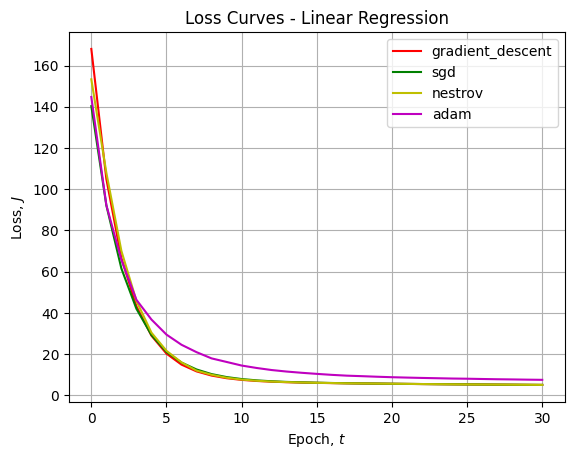

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to plot loss curves over epochs
plot_loss_curves(loss_histories=[lr_model_gd.loss_history,
                                 lr_model_sgd.loss_history,
                                 lr_model_nestrov.loss_history,
                                 lr_model_adam.loss_history],
                 model_names = [lr_model_gd.varient,
                                lr_model_sgd.varient,
                                lr_model_nestrov.varient,
                                lr_model_adam.varient],
                title="Loss Curves - Linear Regression")

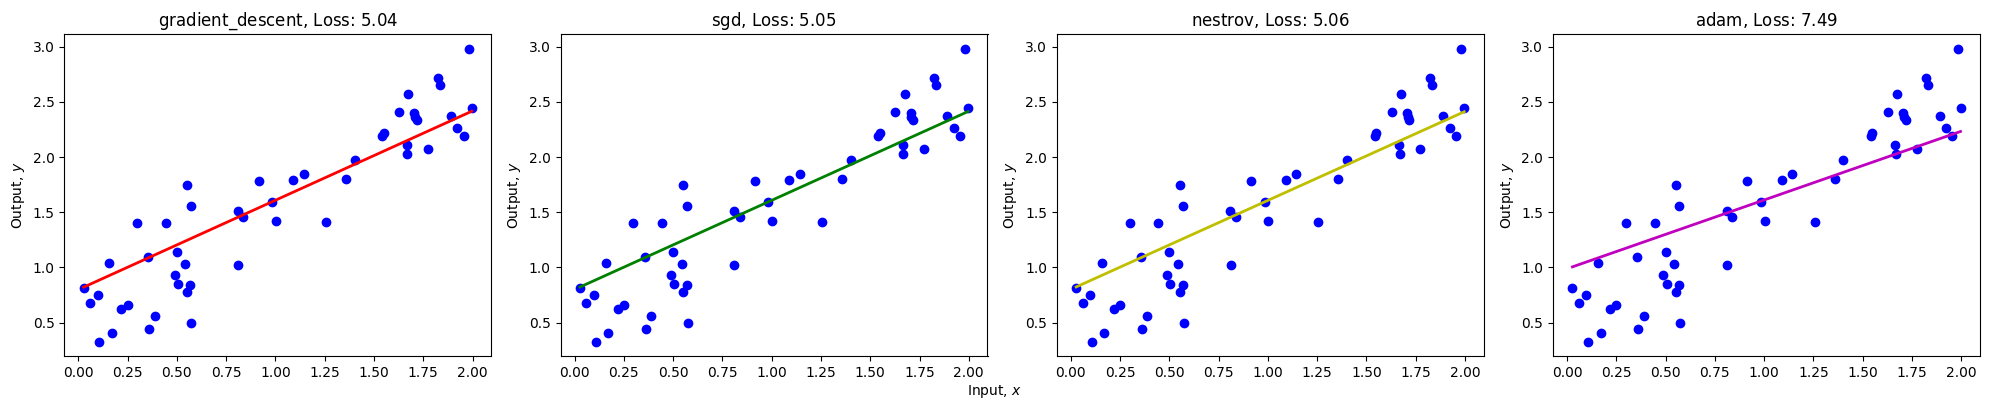

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to plot the models
draw_models([lr_model_gd, lr_model_sgd, lr_model_nestrov, lr_model_adam])

#### 1.6.1 Loss Surface Visualization (10 points)

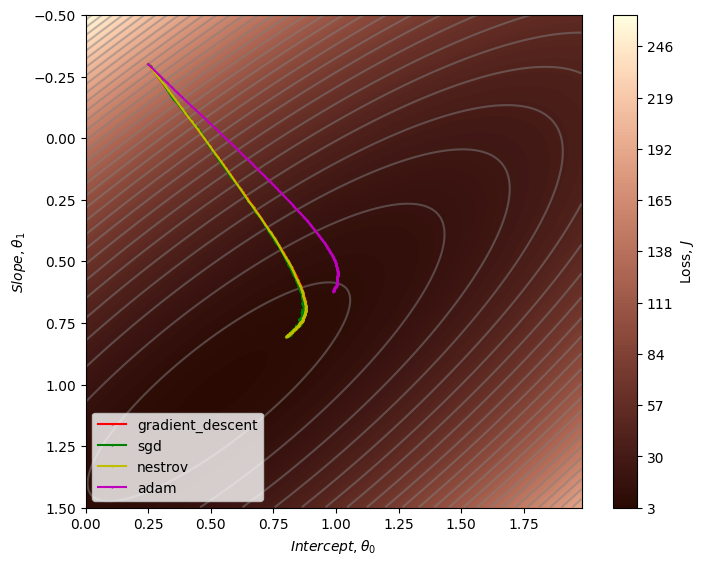

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to plot the loss surface and the trajectory of the weights
draw_loss_function(base_model=lr_model_gd,
                   theta_iters=True,
                   theta_histories=[lr_model_gd.theta_history,
                                    lr_model_sgd.theta_history,
                                    lr_model_nestrov.theta_history,
                                    lr_model_adam.theta_history],
                   model_names=[lr_model_gd.varient,
                                lr_model_sgd.varient,
                                lr_model_nestrov.varient,
                                lr_model_adam.varient])

**Question** <br>
> Comment on the shape of the loss surface for the Linear Regression model.<br>

<span style="color:green;"> **Answer** </span>
> <span style="color:green;"> Adam takes a different optimization path compared to SGD, Nesterov, and Gradient Descent. Due to its adaptive learning rates it initially converges quickly but settles at a higher minimum point. This results in a higher final loss. On the other hand, SGD, Nesterov, and GD follow more gradual and stable paths, allowing them to reach the global minimum more effectively. </span>

**Question** <br>
> Explain the differences in the trajectories taken by thetha values for each of the $4$ Linear Regression models.<br>

<span style="color:green;"> **Answer** </span>
> <span style="color:green;"> The trajectories of the four models—GD, SGD, Nesterov, and Adam all show some overshooting during updates. GD follows a smooth and steady path, while SGD is more erratic due to updates from mini-batches. Nesterov is faster and smoother because of the momentum term. Adam overshoots less than the others, especially for theta_0, but it settles earlier in a higher local minimum, making it less optimal in the long run. </span>

## Part 2: Learning Rate Decay with Gabor Model (40 points)

### 2.1 Learning Rate Decay (10 points)

#### 2.1.1 Auto-reduce (5 points)

In [ ]:
def auto_reduce(initial_lr: float, eta: float, epoch: int, max_epochs: int, n_events: int) -> float:
    """
    Reduces the learning rate of the model based on auto-reduce schedule.
    Args:
        initial_lr: The initial learning rate set for the model.
        eta: The constant decay rate used at each auto-reduce event.
        epoch: The current epoch number
        max_epochs: The maximum number of epochs used in training.
    Returns:
        An updated learning rate.
    """
    if max_epochs % n_events != 0:
        raise ValueError("max_epochs should be divisible by n_events")

    auto_reduce_splits = max_epochs // n_events

    j = epoch // auto_reduce_splits  # Number of reductions so far

    updated_lr = initial_lr * (eta ** j)
    return updated_lr  # Return a scalar value instead of an array

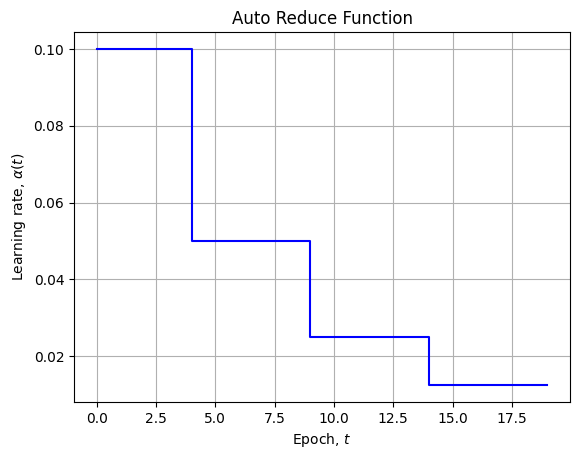

In [ ]:
# ----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to plot the auto-reduce learning rate schedule with varying parameters
plot_auto_reduce(auto_reduce, initial_lr=0.1, eta=0.5, max_epochs=20, n_events=4)

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
test_auto_reduce(auto_reduce)

All tests passed!


#### 2.1.1 Polynomial Decay (5 points)

In [ ]:
def poly_decay(initial_lr: float, final_lr: float, epoch: int, max_epochs: int, eta: float) -> float:
    """
    Reduces the learning rate of the model based on polynomial decay schedule.
    Args:
        initial_lr: The initial learning rate set for the model.
        final_lr: The final learning rate set for the model.
        epoch: The current epoch number
        max_epochs: The maximum number of epochs used in training.
        eta: The polynomial decay rate.
    Returns:
        An updated learning rate.
    """

    updated_lr = (final_lr - initial_lr) * (epoch / max_epochs) ** eta + initial_lr
    return updated_lr

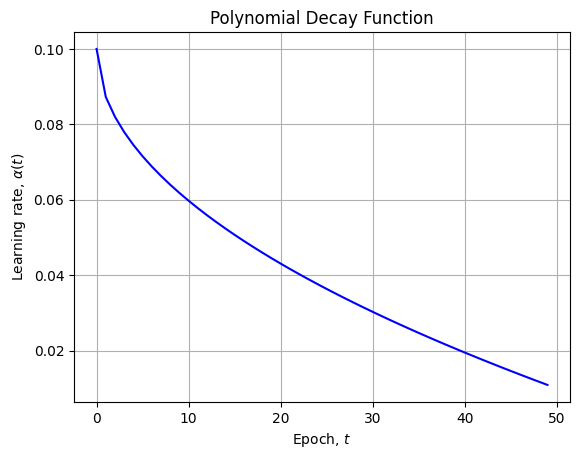

In [ ]:
# ----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to plot the polynomial decay learning rate schedule with varying parameters
plot_poly_decay(poly_decay, initial_lr=0.1, final_lr= 0.01, eta=0.5, max_epochs=50)

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
test_poly_decay(poly_decay)

All tests passed!


### 2.2 The Gabor Model (20 points)

#### 2.2.1 Data for Gabor model
The data used in this section is borrowed from [Understanding Deep Learning](https://github.com/udlbook/udlbook/tree/main/Notebooks).

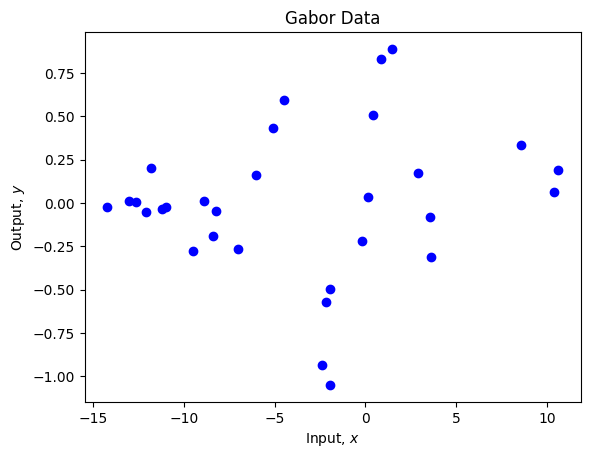

In [ ]:
# ----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the cell to generate data for Gabor model
data_x = np.array([-1.920e+00,-1.422e+01,1.490e+00,-1.940e+00,-2.389e+00,-5.090e+00,
                 -8.861e+00,3.578e+00,-6.010e+00,-6.995e+00,3.634e+00,8.743e-01,
                 -1.096e+01,4.073e-01,-9.467e+00,8.560e+00,1.062e+01,-1.729e-01,
                  1.040e+01,-1.261e+01,1.574e-01,-1.304e+01,-2.156e+00,-1.210e+01,
                 -1.119e+01,2.902e+00,-8.220e+00,-1.179e+01,-8.391e+00,-4.505e+00])
data_y = np.array([-1.051e+00,-2.482e-02,8.896e-01,-4.943e-01,-9.371e-01,4.306e-01,
                  9.577e-03,-7.944e-02 ,1.624e-01,-2.682e-01,-3.129e-01,8.303e-01,
                  -2.365e-02,5.098e-01,-2.777e-01,3.367e-01,1.927e-01,-2.222e-01,
                  6.352e-02,6.888e-03,3.224e-02,1.091e-02,-5.706e-01,-5.258e-02,
                  -3.666e-02,1.709e-01,-4.805e-02,2.008e-01,-1.904e-01,5.952e-01])

plot_data(data_x, data_y, "Gabor Data")

#### 2.2.2 The `GaborModel` class (15 points)

In [ ]:
class GaborModel:
    def __init__(self, data_x: np.ndarray, data_y: np.ndarray, theta: np.ndarray, initial_lr: float, lr_decay_name: str, num_batches: int, max_epochs: int, n_events: int = 5, final_lr: float = 0.001, eta: float = 0.999):

        self.name = 'Gabor'
        self.varient = lr_decay_name

        self.data_x = data_x
        self.data_y = data_y

        self.num_batches = num_batches
        self.max_epochs = max_epochs

        self.theta = theta
        self.theta_history = []
        self.theta_history.append(self.theta)

        self.lr = initial_lr
        self.initial_lr = initial_lr

        if self.varient == "auto_reduce":
            self.n_events = n_events
            self.eta = eta
            self.lr_decay_fn = auto_reduce
        elif self.varient == "poly_decay":
            self.final_lr = final_lr
            self.eta = eta
            self.lr_decay_fn = poly_decay

        self.loss_history = []

        valid_names = ["const", "auto_reduce", "poly_decay"]
        assert self.varient in valid_names, f"Name Error: decar_lr_name should be one of the follows: {valid_names}"

        self.optimizer_name = "sgd"
        self.optimizer_step = gradient_descent_step


    def model(self, data_x: np.ndarray) -> np.ndarray:
        theta_0 = self.theta[0]
        theta_1 = self.theta[1]
        y_pred = np.sin(theta_0 + 0.06 * theta_1 * data_x) * np.exp(-(theta_0 + 0.06 * theta_1 * data_x) ** 2 / 32.0)

        return y_pred

    def compute_cost(self, data_x: np.ndarray, data_y: np.ndarray) -> np.ndarray:

        predictions = self.model(data_x)

        squared_errors = (predictions - data_y) ** 2

        cost = np.sum(squared_errors)

        return cost

    def compute_gradient(self, data_x: np.ndarray, data_y: np.ndarray) -> np.ndarray:

        theta_0 = self.theta[0]
        theta_1 = self.theta[1]

        predictions = self.model(data_x)
        errors = predictions - data_y

        z = theta_0 + 0.06 * theta_1 * data_x
        partial_f_theta_0 = np.exp(-(z**2)/32)*(np.cos(z)-(((z*np.sin(z))/16)))
        partial_f_theta_1 = (0.06*data_x)*np.exp(-(z**2)/32)*(np.cos(z)-((z*np.sin(z)/16)))

        gradient_theta_0 = np.sum(2 * errors * partial_f_theta_0)
        gradient_theta_1 = np.sum(2 * errors * partial_f_theta_1)

        gradient = np.array([[gradient_theta_0], [gradient_theta_1]])

        return gradient

#### 2.2.3 Gabor model setups (5 points)

In [ ]:
initial_theta = np.array([[-1.75], [21.5]])
max_epochs = 100
num_batches = 5


gabor_model_const = GaborModel(
    data_x=data_x,
    data_y=data_y,
    theta=initial_theta,
    initial_lr=0.1,
    lr_decay_name="const",
    num_batches=num_batches,
    max_epochs=max_epochs
)

gabor_model_auto_reduce = GaborModel(
    data_x=data_x,
    data_y=data_y,
    theta=initial_theta,
    initial_lr=0.1,
    lr_decay_name="auto_reduce",
    num_batches=num_batches,
    max_epochs=max_epochs,
    n_events=5,
    eta=0.999
)

gabor_model_poly_decay = GaborModel(
    data_x=data_x,
    data_y=data_y,
    theta=initial_theta,
    initial_lr=0.1,
    lr_decay_name="poly_decay",
    num_batches=num_batches,
    max_epochs=max_epochs,
    final_lr=0.01,
    eta=0.999
)


### 2.3 Gabor models training (15 points)

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
interval = 20
# Run the code below to train the models
train_model(gabor_model_const, interval=interval)
train_model(gabor_model_auto_reduce, interval=interval)
train_model(gabor_model_poly_decay, interval=interval)

#------------ Training Gabor - const ------------ #
Epoch: 0 | Loss: 11.411 | theta_0: -0.649 | theta_1: 21.519
Epoch: 20 | Loss: 2.124 | theta_0: 0.175 | theta_1: 20.710
Epoch: 40 | Loss: 1.855 | theta_0: 0.145 | theta_1: 19.932
Epoch: 60 | Loss: 1.522 | theta_0: 0.094 | theta_1: 19.128
Epoch: 80 | Loss: 1.243 | theta_0: 0.095 | theta_1: 18.361
Epoch: 100 | Loss: 0.997 | theta_0: 0.026 | theta_1: 17.697


#------------ Training Gabor - auto_reduce ------------ #
Epoch: 0 | Loss: 12.996 | theta_0: -1.089 | theta_1: 21.548
Epoch: 20 | Loss: 2.165 | theta_0: 0.203 | theta_1: 20.744
Epoch: 40 | Loss: 1.793 | theta_0: 0.133 | theta_1: 19.975
Epoch: 60 | Loss: 1.526 | theta_0: 0.070 | theta_1: 19.177
Epoch: 80 | Loss: 1.208 | theta_0: 0.054 | theta_1: 18.408
Epoch: 100 | Loss: 0.982 | theta_0: 0.072 | theta_1: 17.737


#------------ Training Gabor - poly_decay ------------ #
Epoch: 0 | Loss: 13.623 | theta_0: -1.254 | theta_1: 21.523
Epoch: 20 | Loss: 2.246 | theta_0: 0.223 | theta_1: 20.79

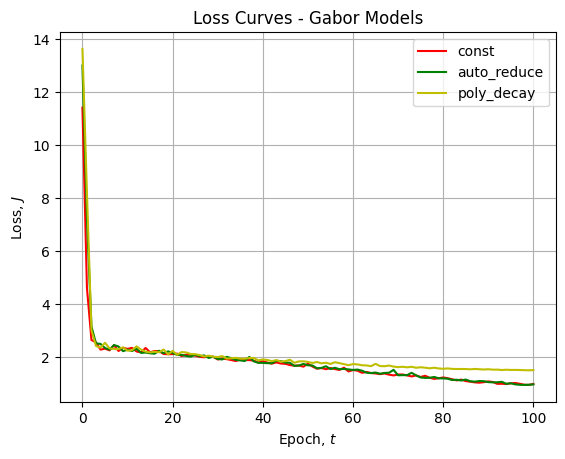

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to plot loss curves over epochs
plot_loss_curves(loss_histories=[gabor_model_const.loss_history,
                                 gabor_model_auto_reduce.loss_history,
                                 gabor_model_poly_decay.loss_history],
                 model_names = [gabor_model_const.varient,
                                gabor_model_auto_reduce.varient,
                                gabor_model_poly_decay.varient],
                title="Loss Curves - Gabor Models")

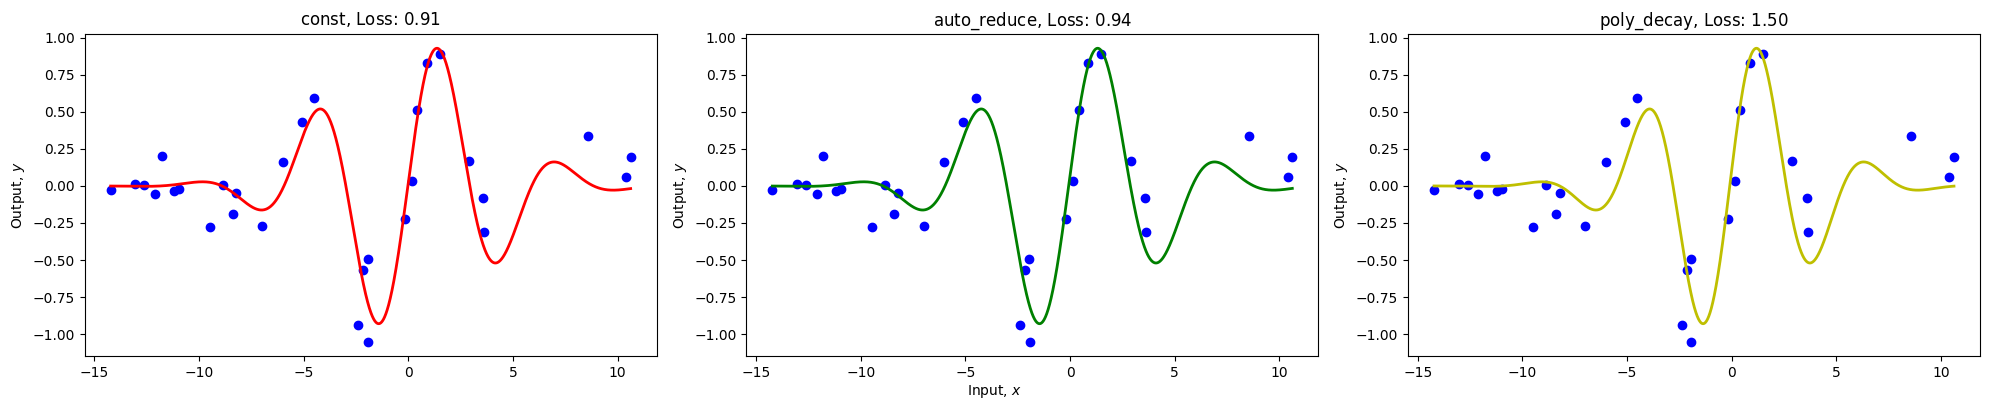

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to plot the models
draw_models([gabor_model_const, gabor_model_auto_reduce, gabor_model_poly_decay])

**Question** <br>
> Which Gabor model across the $3$ varients fits best to the data? Explain your answer.<br>


<span style="color:green;"> **Answer** </span>
> <span style="color:green;"> Constant learning rate performs the best, with the lowest loss at the end of training, followed closely by auto-reduce. Polynomial decay performs the worst in this case, making it the least optimal choice for the data. </span>

#### 2.3.1 Loss Surface Visualization (10 points)

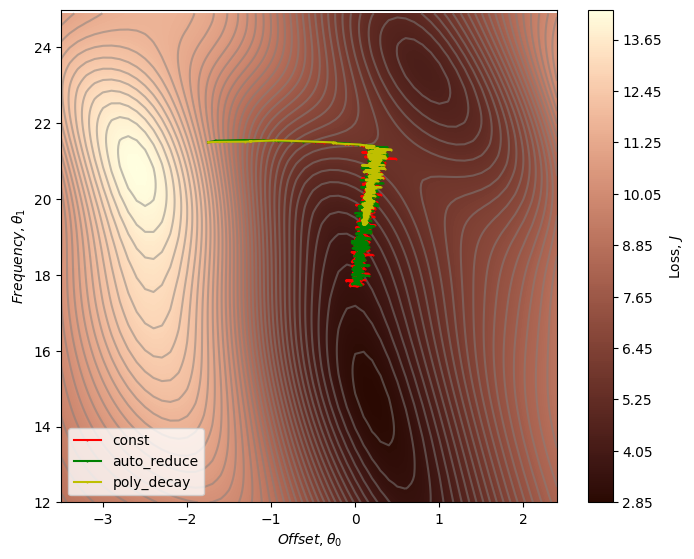

In [ ]:
#----------------------------- DONOT MODIFY CODE BELOW THIS LINE ---------------------------------- #
# Run the code below to plot the loss surface and the trajectory of the weights
draw_loss_function(base_model=gabor_model_const,
                   theta_iters=True,
                   theta_histories=[gabor_model_const.theta_history,
                                  gabor_model_auto_reduce.theta_history,
                                  gabor_model_poly_decay.theta_history],
                   model_names=[gabor_model_const.varient,
                                gabor_model_auto_reduce.varient,
                                gabor_model_poly_decay.varient])

**Question** <br>
> Comment on the shape of the loss surface for the Gabor Model. How is it different from Linear Regression model.<br>

<span style="color:green;"> **Answer** </span>
> <span style="color:green;"> The Gabor loss surface has many local minima due to its nonlinear nature which creates a non-convex surface where the optimizer can easily get stuck in these local minima, leading to irregular updates and slower convergence. In contrast, the Linear Regression model has a smooth, convex loss surface with a single global minimum, making optimization straightforward. </span>

**Question** <br>
> Explain the differences in the trajectories taken by thetha values for each of the $3$ Gabor models.<br>

<span style="color:green;"> **Answer** </span>
> <span style="color:green;"> The trajectories are very similar, showing jerky and irregular movements due to the non-convex nature of the loss surface. All models experience sharp changes in direction, however, the polynomial decay model tends to slow down and stop earlier, as its learning rate decreases more significantly over time, resulting in less aggressive updates compared to the other two models. </span>

<div align="center">

## End of Assignment

</div>